# Mounting Google Drive

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# importing library


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
!ls -al

total 16
drwxr-xr-x 1 root root 4096 Aug 25 13:35 .
drwxr-xr-x 1 root root 4096 Sep  1 06:13 ..
drwxr-xr-x 4 root root 4096 Aug 25 13:35 .config
drwxr-xr-x 1 root root 4096 Aug 25 13:35 sample_data


# loading file

In [9]:
# delete 'Index' because it is provided when converted to a data frame
# delete 'Standard_Weight' because it is determined by the hegith
file_df = pd.read_csv('/gdrive/MyDrive/Colab/Predicting_Body_Fat_Rate/Train_Data.csv')
target_name = 'Body_Fat_Rate'
no_need_features = ['Index', 'Standard_Weight']
category_features = ['Sex']

# Data Preprocessing

In [10]:
# arrange X and y
file_df.drop(no_need_features, axis=1, inplace=True)
y_target = file_df[target_name]
X_features = file_df.drop([target_name],axis=1,inplace=False)

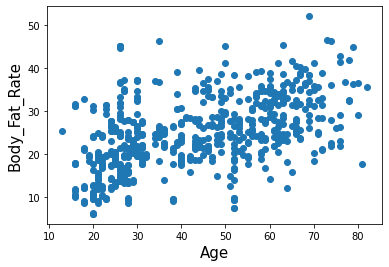

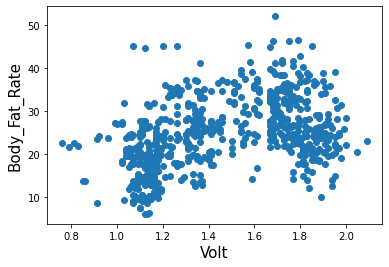

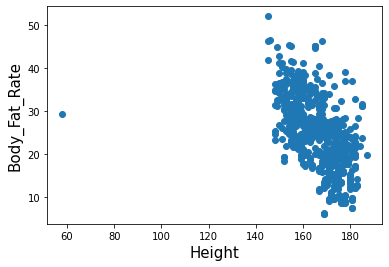

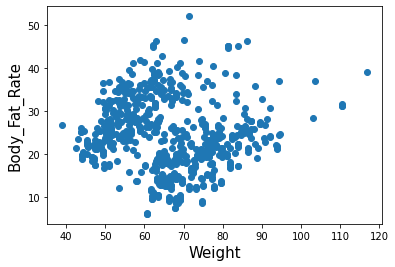

In [11]:
# visualize data to find outliers
for feature in X_features.drop(category_features, axis=1, inplace=False):
    plt.scatter(x = file_df[feature], y = y_target)
    plt.ylabel(target_name, fontsize=15)
    plt.xlabel(feature, fontsize=15)
    plt.show()

In [12]:
# remove outlier
outlier_name = 'Height'
cond1 = file_df[outlier_name] < 60
cond2 = file_df[target_name] < 30
outlier_index = X_features[cond1 & cond2].index
print('Outlier index :', outlier_index.values)
print('X_feature shape before Outlier is removed:', X_features.shape)
X_features.drop(outlier_index , axis=0, inplace=True)
y_target.drop(outlier_index, axis=0, inplace=True)
print('X_feature shape after Outlier is removed:', X_features.shape)

Outlier index : [222]
X_feature shape before Outlier is removed: (684, 5)
X_feature shape after Outlier is removed: (683, 5)


In [13]:
# figure out the extent of distortion in features --> if the degree of distortion is high(>1 or <-1), log transformation is performed.
non_category_features_index = X_features.drop(category_features, axis=1, inplace=False).dtypes.index
skew_features = X_features[non_category_features_index].apply(lambda x : skew(x))
print(skew_features.sort_values(ascending=False))
skew_features_need_change = skew_features[skew_features < -1]
X_features[skew_features_need_change.index] = np.log1p(X_features[skew_features_need_change.index])
print(skew_features_need_change)

# there's nothing to change here
# if the log transformation is applied, the target column also needs to be normal distribution
# y_target_log = np.log1p(y_target)
# print(y_target)
# print(y_target_log)

Weight    0.449733
Age       0.351303
Volt      0.212471
Height   -0.239014
dtype: float64
Series([], dtype: float64)


In [14]:
# change the category feature to One-Hot Encoding --> 'Sex'
X_features_ohe = pd.get_dummies(X_features, columns=category_features)
# print(X_features_ohe)

In [15]:
# split train/test data based on dataset
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target, test_size=0.2, random_state=0)

# Train

In [16]:
# declare the model
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
en_reg = ElasticNet()
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()
gbm_reg = GradientBoostingRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

In [28]:
# find best parameters
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV best average RMSE value: {1}, best alpha:{2}'.format(model.__class__.__name__,np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

# optimal values were found by running it several times, where it was abbreviated for the simplicity of the code.
ridge_params = { 'alpha':[0.01, 0.05, 0.09, 0.1, 0.11, 0.12, 0.5, 1, 3, 5, 8, 10, 12, 15, 20, 30, 40, 50]}
lasso_params = { 'alpha':[0.01, 0.05, 0.09, 0.1, 0.11, 0.12, 0.5, 1, 3, 5, 8, 10, 12, 15, 20, 30, 40, 50]}
en_params = { 'alpha':[0.07, 0.1, 0.5, 1, 3]}
dt_params = {'max_depth':[1,3,5,7,9]}
rf_params = {'n_estimators':[600, 700], 'max_depth' : [5, 14], 'min_samples_leaf' : [1, 2], 'min_samples_split' : [1, 2]}
gbm_params = {'learning_rate': [0.02, 0.1], 'n_estimators':[500], 'subsample': [0.05, 1]}
xgb_params = {'objective' : ['reg:squarederror'], 'colsample_bytree': [0.1, 1], 'eta': [0.1, 1], 'max_depth': [1, 3], 'min_child_weight': [1, 3], 'n_estimators':[100, 120]}
lgbm_params = {'learning_rate': [0.03, 1], 'max_depth': [1, 3], 'min_child_samples': [5, 10], 'n_estimators':[300, 1000], 'num_leaves': [1, 3]}

best_rige = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)
best_en = get_best_params(en_reg, en_params)
best_dt = get_best_params(dt_reg, dt_params)
best_rf = get_best_params(rf_reg, rf_params)
best_gbm = get_best_params(gbm_reg, gbm_params)
best_xgb = get_best_params(xgb_reg, xgb_params)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)

Ridge 5 CV best average RMSE value: 4.1692, best alpha:{'alpha': 8}
Lasso 5 CV best average RMSE value: 4.1906, best alpha:{'alpha': 0.05}
ElasticNet 5 CV best average RMSE value: 4.2305, best alpha:{'alpha': 0.07}
DecisionTreeRegressor 5 CV best average RMSE value: 5.2205, best alpha:{'max_depth': 7}
RandomForestRegressor 5 CV best average RMSE value: 4.0536, best alpha:{'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
GradientBoostingRegressor 5 CV best average RMSE value: 3.8334, best alpha:{'learning_rate': 0.02, 'n_estimators': 500, 'subsample': 0.05}
XGBRegressor 5 CV best average RMSE value: 3.902, best alpha:{'colsample_bytree': 1, 'eta': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 120, 'objective': 'reg:squarederror'}
LGBMRegressor 5 CV best average RMSE value: 3.9306, best alpha:{'learning_rate': 0.03, 'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 1000, 'num_leaves': 3}


In [36]:
# define the model
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=8)
lasso_reg = Lasso(alpha=0.05)
en_reg = ElasticNet(alpha=0.07)
dt_reg = DecisionTreeRegressor(max_depth=7)
rf_reg = RandomForestRegressor(max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=600, n_jobs=-1)
gbm_reg = GradientBoostingRegressor(learning_rate=0.02, n_estimators=500, subsample=0.05)
xgb_reg = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, eta=0.1, min_child_weight=3, max_depth=3, n_estimators=120)
lgbm_reg = LGBMRegressor(learning_rate=0.03, max_depth=3, min_child_samples=5, n_estimators=1000, num_leaves=3)

In [30]:
# return the result of each model
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    # scale back by expm1() if the predicted result is predicted by log-translated data
    # y_test = np.expm1(y_test)
    # pred = np.expm1(pred)
    print('\n###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

# calculate MAE, MSE, RMSE, RMSLE
def evaluate_regr(y, pred):
    mae_val = mean_absolute_error(y, pred)
    mse_val = mean_squared_error(y, pred)
    rmse_val = rmse(y, pred)
    rmsle_val = rmsle(y,pred)
    r2_val = r2_score(y, pred)
    print('MAE: {0:.3F}, MSE: {1:.3F}, RMSE: {2:.3F}, RMSLE: {3:.3F}, R2: {4:.3F}'.format(mae_val, mse_val, rmse_val, rmsle_val, r2_val))

# calculate RMSLE using log1p(), not log() because of the NaN issue 
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# calculate RMSE using mean_square_error() of Scikit-learn 
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def print_coefficient(models):
    for model in models:
        print('\n###',model.__class__.__name__,'###')
        coeff = pd.Series(data=np.round(model.coef_, 3), index=X_features_ohe.columns )
        print(coeff.sort_values(ascending=False))

# visualize coefficients of features for linear regression models
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=4)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# extract top 3 of features, bottom 3 efficient for linear regression models
def get_top_bottom_coef(model):
    # create Series objects based on coef_ property
    coef = pd.Series(model.coef_, index=X_features_ohe.columns)
    coef_high = coef.sort_values(ascending=False).head(3)
    coef_low = coef.sort_values(ascending=False).tail(3)
    return coef_high, coef_low

# visualize coefficients of features for regression tree models 
def visualize_ftr_importances(models):
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=5)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        ftr_top6 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=17)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top6.values, y=ftr_top6.index , ax=axs[i_num])

# extract top 3 of features, bottom 3 efficient for regression tree models
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features_ohe.columns)
    ftr_top6 = ftr_importances.sort_values(ascending=False)[:6]
    return ftr_top6

In [38]:
# linear regression models
models_linear = [lr_reg, ridge_reg, lasso_reg, en_reg]
for model in models_linear:
    get_model_predict(model,X_train, X_test, y_train, y_test)

# regression tree models
models_tree = [dt_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]
for model in models_tree:
    get_model_predict(model,X_train, X_test, y_train, y_test)


### LinearRegression ###
MAE: 2.607, MSE: 10.876, RMSE: 3.298, RMSLE: 0.149, R2: 0.829

### Ridge ###
MAE: 2.627, MSE: 11.071, RMSE: 3.327, RMSLE: 0.151, R2: 0.826

### Lasso ###
MAE: 2.618, MSE: 10.987, RMSE: 3.315, RMSLE: 0.151, R2: 0.827

### ElasticNet ###
MAE: 2.686, MSE: 11.675, RMSE: 3.417, RMSLE: 0.156, R2: 0.816

### DecisionTreeRegressor ###
MAE: 2.556, MSE: 13.204, RMSE: 3.634, RMSLE: 0.146, R2: 0.792

### RandomForestRegressor ###
MAE: 2.046, MSE: 8.280, RMSE: 2.877, RMSLE: 0.118, R2: 0.870

### GradientBoostingRegressor ###
MAE: 2.409, MSE: 9.901, RMSE: 3.147, RMSLE: 0.140, R2: 0.844

### XGBRegressor ###
MAE: 2.267, MSE: 9.307, RMSE: 3.051, RMSLE: 0.133, R2: 0.854

### LGBMRegressor ###
MAE: 2.413, MSE: 9.765, RMSE: 3.125, RMSLE: 0.138, R2: 0.846



### LinearRegression ###
Sex_0     4.856
Volt      3.548
Weight    0.544
Age       0.044
Height   -0.559
Sex_1    -4.856
dtype: float64

### Ridge ###
Sex_0     4.477
Volt      2.879
Weight    0.540
Age       0.049
Height   -0.590
Sex_1    -4.477
dtype: float64

### Lasso ###
Sex_0     9.156
Volt      2.755
Weight    0.540
Age       0.051
Sex_1    -0.000
Height   -0.581
dtype: float64

### ElasticNet ###
Sex_0     3.875
Volt      1.932
Weight    0.532
Age       0.055
Height   -0.638
Sex_1    -3.876
dtype: float64


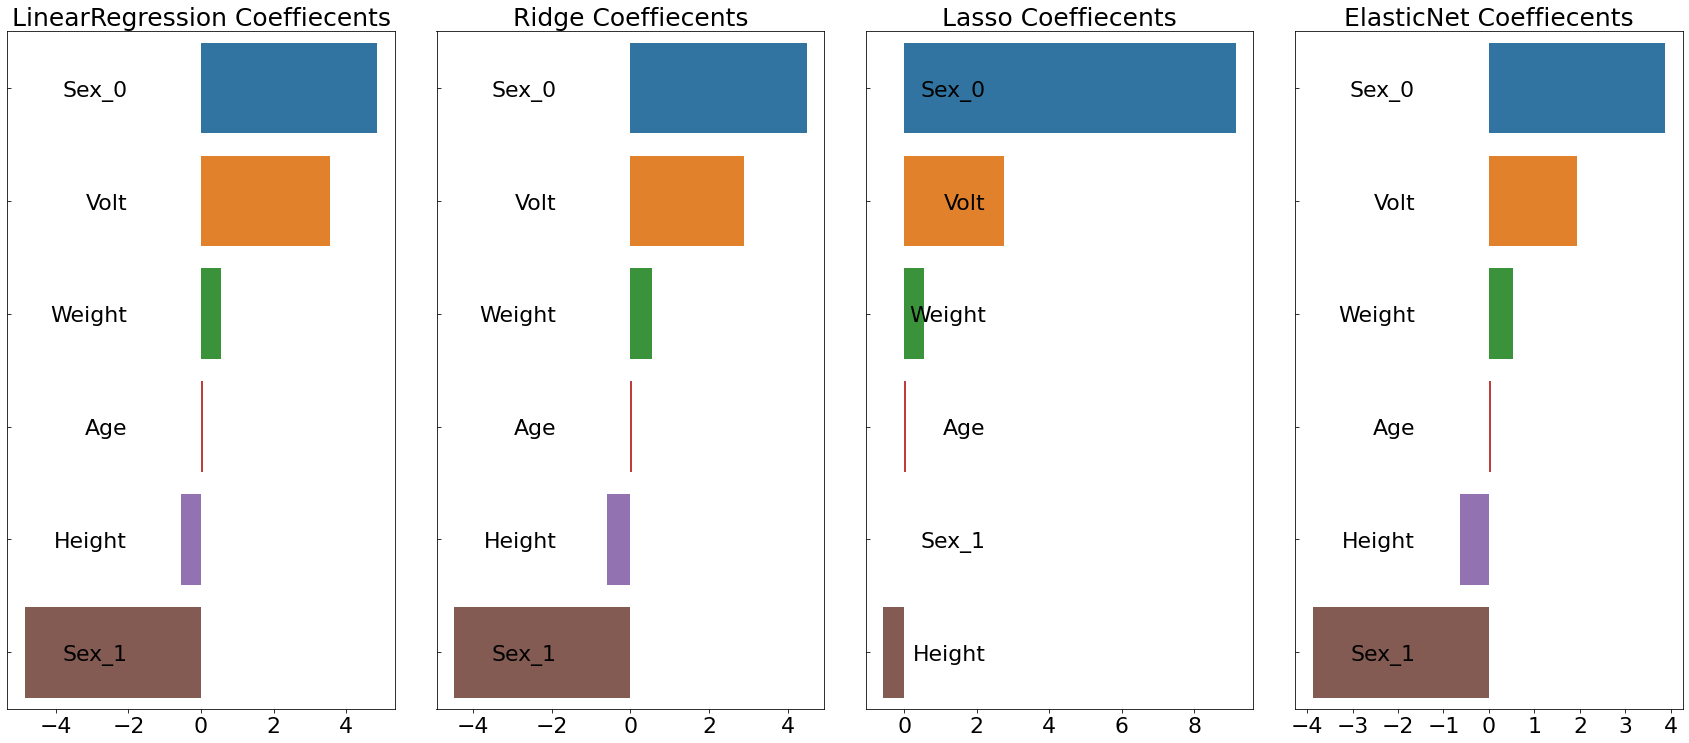

In [39]:
# visualize coefficients of linear regression models
print_coefficient(models_linear)
visualize_coefficient(models_linear)

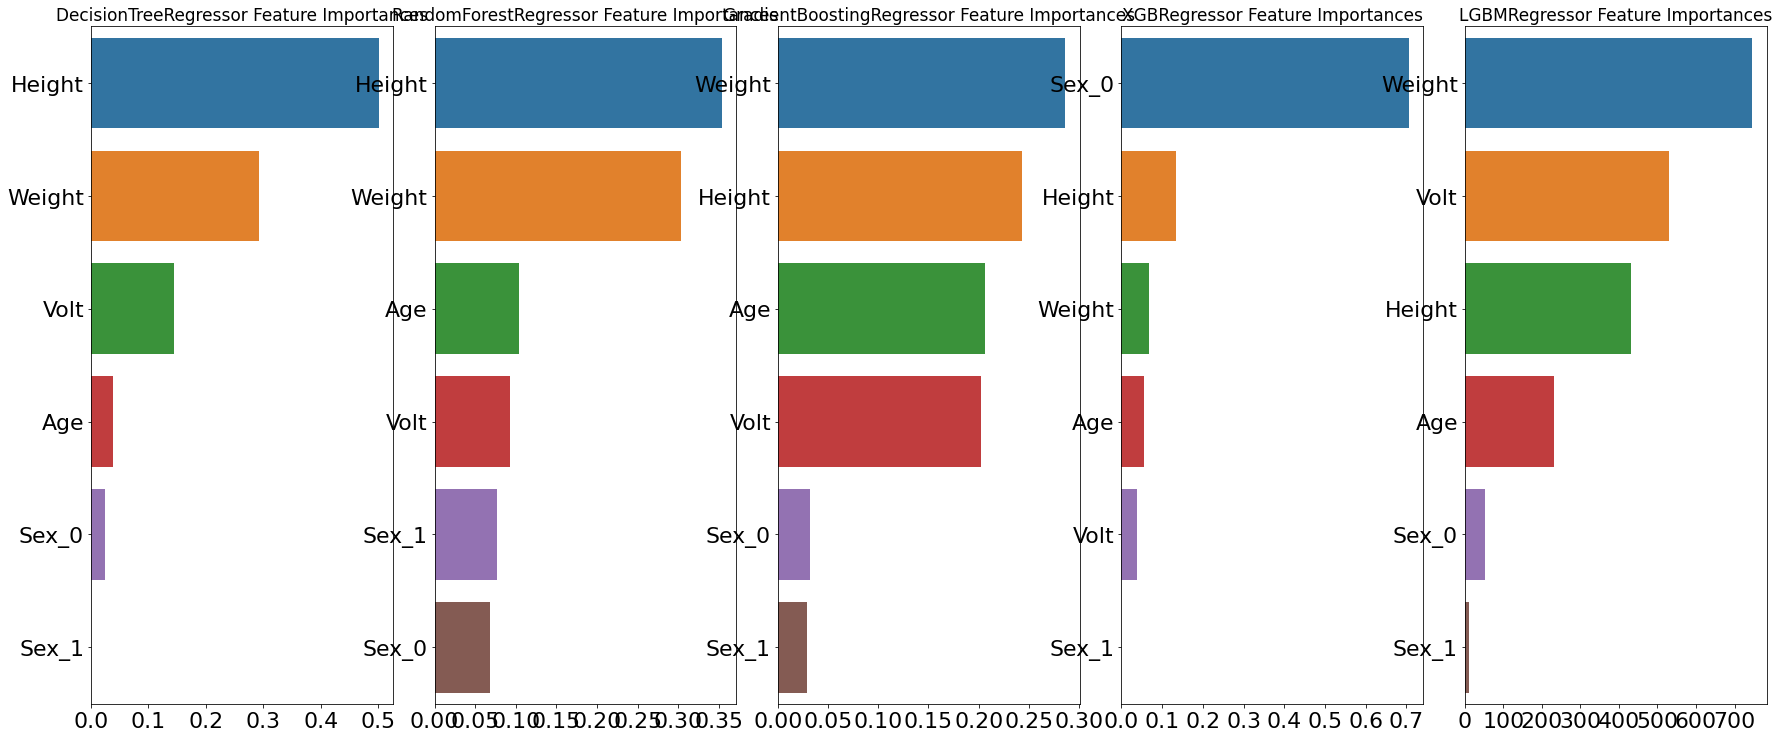

In [40]:
# visualize coefficients of regression tree models
visualize_ftr_importances(models_tree)

In [42]:
# train model
model = RandomForestRegressor(max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=600, n_jobs=-1)
model.fit(X_features_ohe, y_target)

# mixed model
# mixed model
# model1 = RandomForestRegressor(max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=600, n_jobs=-1)
# model2 = XGBRegressor(eta=0.1, min_child_weight=3, max_depth=3, n_estimators=120)
# model1.fit(X_features_ohe, y_target)
# model2.fit(X_features_ohe, y_target)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Test

In [45]:
# test data file load
# delete 'Index' and 'Standard_Weight'
test_df = pd.read_csv('/gdrive/MyDrive/Colab/Predicting_Body_Fat_Rate/Test_Data.csv')

In [46]:
# arrange X and y
test_df.drop(no_need_features, axis=1, inplace=True)
y_test = test_df[target_name]
X_test = test_df.drop([target_name],axis=1,inplace=False)

# change the category feature to One-Hot Encoding --> 'Sex'
X_test_ohe = pd.get_dummies(X_test, columns=category_features)

In [49]:
# single model
predict_value = model.predict(X_test_ohe)
results = []
print("**Single Model**")
for x in predict_value:
    results.append(round(x,1))
print(results[:5])

# mixed model
# pred1 = model1.predict(X_test_ohe)
# pred2 = model2.predict(X_test_ohe)
# predict_value = 0.8 * pred1 + 0.2 * pred2
# print("**Mixed Model**")
# for x in predict_value:
#     results.append(round(x,1))
# print(results[:5])

**Single Model**
[25.1, 24.0, 13.3, 20.4, 34.7]
